In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sma
import scipy.stats as stats

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_rainbow

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold,LeaveOneOut,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, RFECV

# terminal --> pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Importing the data from csv file:-

data = pd.read_csv('Concrete_Data.csv')
data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


## Data Preprocessing

In [6]:
# Shape of data:-

print('No of rows:',data.shape[0])
print('No of columns:',data.shape[1])

No of rows: 1030
No of columns: 9


In [8]:
# descriptive summary of data:-

data.describe().T

,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
Blast Furnace Slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
Fly Ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
Water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
Superplasticizer,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
Coarse Aggregate,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
Fine Aggregate,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
Age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
Concrete compressive strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


In [19]:
# Target variable is almost having a normal distribution of data.
# Distribution of rest of the variables will be clear while doing the univariate analysis.

<Axes: >

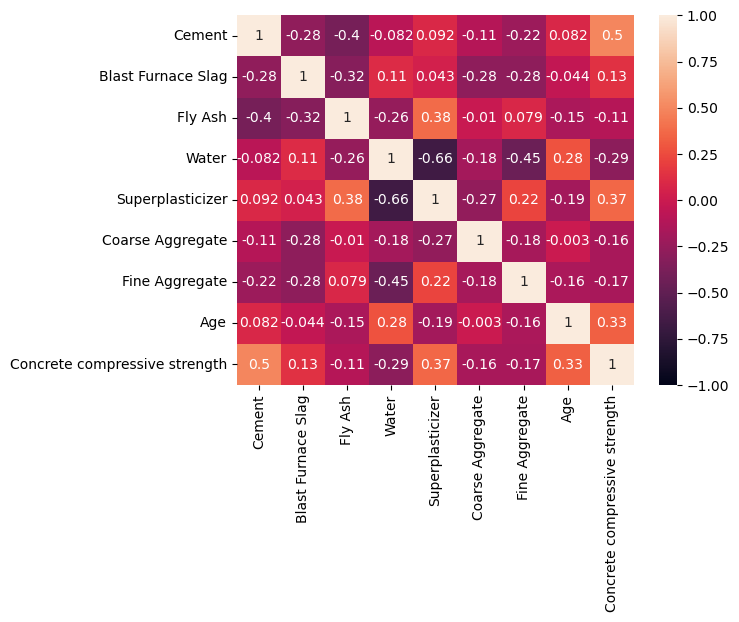

In [9]:
# Checking correlation between features using a heatmap:-

sns.heatmap(data.corr(),annot=True,vmax=1,vmin=-1)

In [23]:
# Target(CCS) has good correlation with Cement, Superplasticizer and Age.
# Water have a good negative correlation with superplasticizer and Fine Aggregate.

In [10]:
# Checking for duplicate rows in the dataset:-

data.duplicated().sum()

25

In [11]:
# Hence, we have 25 duplicate records and we have to remove them:-

data.drop_duplicates(inplace=True)

In [12]:
data.shape

(1005, 9)

In [14]:
# Univariate Analysis of features:-

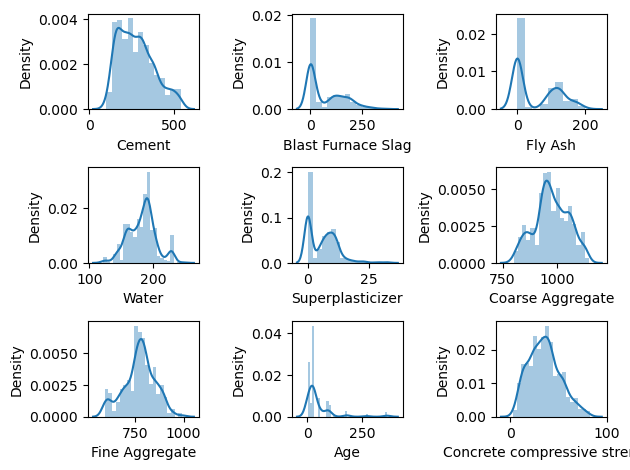

In [15]:
# As all the columns are numerical, we can make distplot for each feature:-

t = 1
for i in data.columns:
    plt.subplot(3,3,t)
    sns.distplot(data[i])
    t+=1
plt.tight_layout()
plt.show()

In [20]:
# As described above, CCS amost have a normal distribution.
# Blast Furnace Slag, Superplasticizer, Fly Ash and Age are highly right skewed.
# Rest features seems to have a normal distribution.

In [16]:
# Shortening the name of target variable (for self convenience):-

data.rename(columns={'Concrete compressive strength':'CCS'},inplace=True)

In [17]:
# Bivariate analysis of features:-

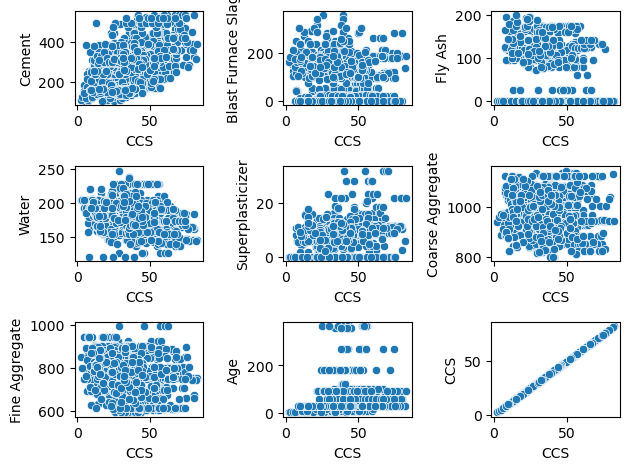

In [18]:
# We can check for scatterplots for each feature with target:-

t = 1
for i in data.columns:
    plt.subplot(3,3,t)
    sns.scatterplot(y=data[i],x=data['CCS'])
    t+=1
plt.tight_layout()
plt.show()

In [22]:
# Target variable(CCS) have good correlation with Cement, Superplasticizer and Age.

In [24]:
# Checking for missing values:-

data.isnull().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
CCS                   0
dtype: int64

In [25]:
# Hence, there are no missing values in the dataset.

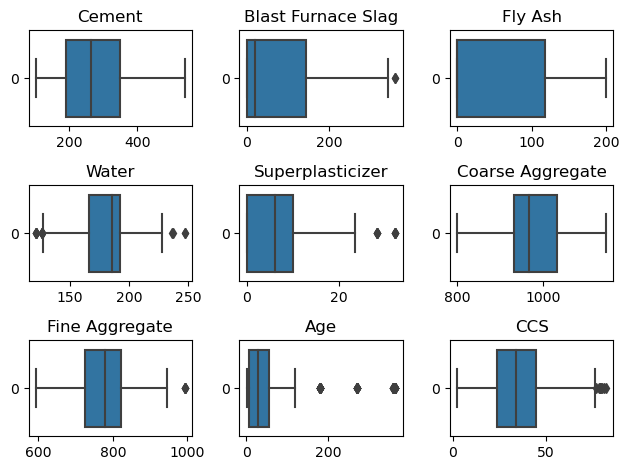

In [29]:
# Checking for outliers:-

t = 1
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot(data[i], orient='h')
    plt.title(i)
    t+=1
plt.tight_layout()
plt.show()

In [30]:
# Age has a lot of outliers.
# There are a few outliers in Blast Furnace Slag, Water, Superplasticizer, fine Aggregate and CCS.

In [31]:
# Since water and cement has high correlation, they will increase multicollinearity.
# Hence, lets take cement to water ratio to get ineraction effect.

data['Cement Water ratio'] = data['Cement']/data['Water']
data.drop(columns=['Cement','Water'],inplace=True)


In [34]:
# Checking if our new feature is significant or not:-

np.corrcoef(data['CCS'],data['Cement Water ratio'])

array([[1.        , 0.54869849],
       [0.54869849, 1.        ]])

In [35]:
# Correlation is good, hence we can keep this feature.

In [36]:
# Doing same for fine and coarse aggregates:-

data['Course Fine ratio'] = data['Coarse Aggregate']/data['Fine Aggregate']

In [38]:
# Checking if our new feature is significant or not:-

np.corrcoef(data['CCS'],data['Course Fine ratio'])

array([[1.        , 0.07549419],
       [0.07549419, 1.        ]])

In [39]:
# Hence, new column is not significant, hence we shall drop it:-

data.drop(columns='Course Fine ratio', inplace=True)

In [51]:
# While checking for VIF below, we see that they show high multicollinearity.
# Hence, its better to drop both of them.

data.drop(columns=['Fine Aggregate','Coarse Aggregate'], inplace=True)

In [52]:
# train test Split
x = data.drop(columns=['CCS'])
y = data['CCS']

x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.80,random_state=3)

In [53]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(804, 5) (804,) (201, 5) (201,)


## Feature Extraction

**Feature Scalling: We do not scale the features to have correct factors or slope for Independent variables. This usually done for distance based algorithms/Models**

## Modeling

In [49]:
# Checking for the assumptions of Linear Regression:-
# 1. Target must be numeric
# yes

In [50]:
# Checking for multicollinearity:-

# VIF
vif_list = []

for i in range(x_train.shape[1]):
    vif_list.append(variance_inflation_factor(x_train.values,i))

pd.DataFrame({'Feature Names':x_train.columns,'VIF':vif_list}).\
sort_values(by='VIF',ascending=False)

,Feature Names,VIF
3,Coarse Aggregate,73.388872
4,Fine Aggregate,60.075380
6,Cement Water ratio,12.310215
2,Superplasticizer,4.463417
1,Fly Ash,3.970852
0,Blast Furnace Slag,2.378240
5,Age,1.587782


In [54]:
# VIF after droppinng Fine and Coarse aggregates:-

vif_list = []

for i in range(x_train.shape[1]):
    vif_list.append(variance_inflation_factor(x_train.values,i))

pd.DataFrame({'Feature Names':x_train.columns,'VIF':vif_list}).\
sort_values(by='VIF',ascending=False)

,Feature Names,VIF
2,Superplasticizer,3.289684
4,Cement Water ratio,2.993382
1,Fly Ash,1.990741
3,Age,1.503062
0,Blast Furnace Slag,1.410024


In [55]:
# Now we have dealt with multicollinearity.
# Now, assumtions to be met before fitting a linear model have been met.

In [57]:
# lets Build a base model:-

x_train_c = sma.add_constant(x_train)
x_test_c = sma.add_constant(x_test)

base_model = sma.OLS(y_train,x_train_c).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CCS   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     234.1
Date:                Thu, 28 Mar 2024   Prob (F-statistic):          9.32e-154
Time:                        20:06:16   Log-Likelihood:                -3018.6
No. Observations:                 804   AIC:                             6049.
Df Residuals:                     798   BIC:                             6077.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -10.1813      1.712     -5.949      0.000     -13.541      -6.822
Blast Furnace Slag     0.0807      0.005     14.752      0.000       0.070       0.091
Fly Ash                0.0776      0.009      8.824      0.000       0.060       0.095
Superplasticizer       0.2073      0.085      2.428      0.015       0.040       0.375
Age                    0.1075      0.006     17.907      0.000       0.096       0.119
Cement Water ratio    18.6725      0.822     22.716      0.000      17.059      20.286
==============================================================================
Omnibus:                        1.789   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.409   Jarque-Bera (JB):                1.780
Skew:                          -0.115   Prob(JB):                        0.411
Kurtosis:                       2.981   Cond. No.                         624.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# R squared is not a good score for our model.
# Also we can see a severe multicollinearity as per condition number.

In [58]:
# Now, we will check for assumtions to be met after fitting a model:-

# Assumption: Liniearity of Model

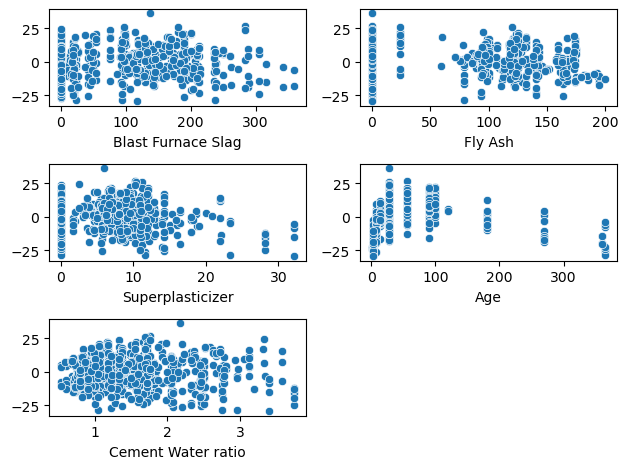

In [59]:
# Graphically:-

t = 1
for i in x_train.columns:
    plt.subplot(3,2,t)
    sns.scatterplot(x=x_train[i],y=base_model.resid)
    t+=1
plt.tight_layout()
plt.show()

In [60]:
# Confirming with help of linear rainbow function:- 

# Ho: Varaibles are linear
# Ha: Variables are not linear
p_val = linear_rainbow(base_model)[1]

if p_val <0.05:
    print('Reject Ho:')
else:
    print('Fail to reject Ho:')
    
# Hence, there is linearity in model.

Fail to reject Ho:


In [61]:
# Assumption of Autocorrelation:-

# Durbin Watson = 1.999 shows that there is no autocorrelation.

In [62]:
# Assumption of Homoskedasticity:-

# Breusch pagan test

# Ho: The variance is same: Homoskedastic
# Ha: The variance is not same: Heteresckedastic

p_value = sma.stats.diagnostic.het_breuschpagan(resid=base_model.resid,exog_het=base_model.model.exog)[1]

if p_value> 0.05:
    print('Fail to reject Ho:')
else:
    print('reject Ho:')

reject Ho:


In [63]:
# Assumption for Normality:-

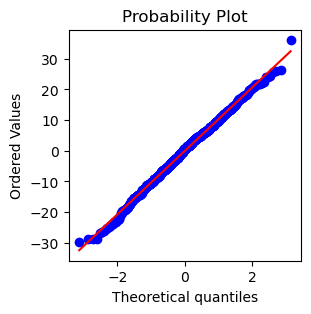

In [66]:
plt.figure(figsize=(3,3))
stats.probplot(base_model.resid,plot=plt)
plt.show()

# Hence, residuals are normally distributed.

In [67]:
# For normality, we can also check for shapiro wilk test:-

# Shapiro Wilk test (N < 5000)

# Ho: The data is normal
# ha: The data is not normal

p_val = stats.shapiro(base_model.resid)[1]

if p_val> 0.05:
    print('Fail to reject Ho:')
else:
    print('reject Ho:')

Fail to reject Ho:


### Model Evaluation

In [68]:
# Now, we will check whats wrong with our base model:-

In [69]:
# Lets define a function for finding various scores easily:-

def validation(test,pred,data):
    r2 = r2_score(test,pred)
    print('R Squared:',r2)
    n = data.shape[0]
    k = data.shape[1]
    r2_adj = 1 - ((1-r2)*(n-1)/(n-k-1))
    print('Adj R Square:',r2_adj)
    print('MSE:',mean_squared_error(test,pred))
    print('RMSE:',np.sqrt(mean_squared_error(test,pred)))
    print('MAE:',mean_absolute_error(test,pred))
    print('MAPE:',mean_absolute_percentage_error(test,pred))

In [70]:
pred_train = base_model.predict(x_train_c)

In [71]:
validation(y_train,pred_train,x_train_c)

R Squared: 0.5946437834289198
Adj R Square: 0.5915921682477071
MSE: 106.81798426312795
RMSE: 10.33527862532636
MAE: 8.28476774569331
MAPE: 0.32921349564122976


In [72]:
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CCS   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     234.1
Date:                Thu, 28 Mar 2024   Prob (F-statistic):          9.32e-154
Time:                        20:22:11   Log-Likelihood:                -3018.6
No. Observations:                 804   AIC:                             6049.
Df Residuals:                     798   BIC:                             6077.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -10.1813      1.712     -5.949      0.000     -13.541      -6.822
Blast Furnace Slag     0.0807      0.005     14.752      0.000       0.070       0.091
Fly Ash                0.0776      0.009      8.824      0.000       0.060       0.095
Superplasticizer       0.2073      0.085      2.428      0.015       0.040       0.375
Age                    0.1075      0.006     17.907      0.000       0.096       0.119
Cement Water ratio    18.6725      0.822     22.716      0.000      17.059      20.286
==============================================================================
Omnibus:                        1.789   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.409   Jarque-Bera (JB):                1.780
Skew:                          -0.115   Prob(JB):                        0.411
Kurtosis:                       2.981   Cond. No.                         624.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
pred_test = base_model.predict(x_test_c)

In [74]:
validation(y_test,pred_test,x_test_c)

R Squared: 0.5822594014463344
Adj R Square: 0.5693395891199323
MSE: 113.01633625418603
RMSE: 10.630914177726487
MAE: 8.61004306730078
MAPE: 0.313060989285349


In [76]:
# Results are bad on both train and test.
# So the model seems to underfitted
# lets try some different algorithm on the model

In [77]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [78]:
dtc = DecisionTreeRegressor()

In [79]:
# Fitting a decision tree:-

dtc.fit(x_train,y_train)
pred_dt = dtc.predict(x_train)

validation(y_train,pred_dt,x_train)

R Squared: 0.9981294283598652
Adj R Square: 0.9981177079861802
MSE: 0.4929261815920396
RMSE: 0.7020870185326314
MAE: 0.10152155887230514
MAPE: 0.003840612641540126


In [80]:
pred_dt = dtc.predict(x_test)

validation(y_test,pred_dt,x_test)

R Squared: 0.8155655856655964
Adj R Square: 0.8108364981185605
MSE: 49.897237327252626
RMSE: 7.063797656165741
MAE: 4.383092868988392
MAPE: 0.14577785692041323


In [81]:
# R squared is good on train(almost 1) but bad on test.
# Hence, it seems overfitting of the model.

In [82]:
gbr = GradientBoostingRegressor()

In [83]:
# Lets fit the gradient boosting model:-

gbr.fit(x_train,y_train)
pred_dt = gbr.predict(x_train)

validation(y_train,pred_dt,x_train)

R Squared: 0.934711672153577
Adj R Square: 0.9343025974176972
MSE: 17.204540824507742
RMSE: 4.147835679545146
MAE: 3.018197332945027
MAPE: 0.10393732300281876


In [85]:
pred_dt = gbr.predict(x_test)

validation(y_test,pred_dt,x_test)

R Squared: 0.8912251814477019
Adj R Square: 0.8884360835361045
MSE: 29.42814634741639
RMSE: 5.424771547947102
MAE: 4.1539127018621
MAPE: 0.13670067996369667


In [89]:
# Hence, gbr seems to be a good model.

In [90]:
x_train.columns

Index(['Blast Furnace Slag', 'Fly Ash', 'Superplasticizer', 'Age',
       'Cement Water ratio'],
      dtype='object')

In [91]:
gbr.feature_importances_

array([0.11193662, 0.01485974, 0.07296865, 0.40356588, 0.39666911])

In [93]:
# According to this model, Age and Cement Water Ratio are the most important features.

In [95]:
gbr.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}